# Marker Determination

In [1]:
import sklearn as sk
import anndata as ad
import scanpy as sc 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sc.settings.n_jobs = -1

In [4]:
import joblib

# Load the RandomForest classifier and the LabelEncoder
rf_classifier = joblib.load('models/rf_classifier_reproduction.pkl')
le = joblib.load('models/le_reproduction.pkl')

ovr_classifier = joblib.load('models/ovr_classifier.pkl')
top_features_log_reg = pd.read_csv('spreadsheets/ovr_top_20_genes_by_cell_type_reproduction.csv')

In [24]:
top_features_log_reg

,Cell Type,Gene,Coefficient
0,AC,Synpr,0.593647
1,AC,Asic2,0.561311
2,AC,Frmd5,0.557747
3,AC,Slc32a1,0.551331
4,AC,Gad1,0.517364
...,...,...,...
475,Rod,Rlbp1,-0.357221
476,Rod,Basp1,-0.345442
477,Rod,Tenm2,-0.342909
478,Rod,Kcnip4,-0.342550


In [18]:
adata = ad.read_h5ad('camr_modeling_input.h5ad')
adata

AnnData object with n_obs × n_vars = 294561 × 2175
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', '

## Major Class Markers

In [23]:
top_features_log_reg_pos = top_features_log_reg[top_features_log_reg['Coefficient'] > 0]
top_features_log_reg_pos

,Cell Type,Gene,Coefficient
0,AC,Synpr,0.593647
1,AC,Asic2,0.561311
2,AC,Frmd5,0.557747
3,AC,Slc32a1,0.551331
4,AC,Gad1,0.517364
...,...,...,...
455,Rod,Epb41,0.272485
456,Rod,Pde6a,0.272482
457,Rod,Dmd,0.270124
458,Rod,Tmem108,0.264541


In [39]:
where_genes = adata.var["feature_name"].astype(str).isin(top_features_log_reg_pos["Gene"])
gene_names = adata.var["feature_name"].astype(str)[where_genes]

In [ ]:
# Now get average expression and percent expressed
feature_expression_pd = pd.DataFrame(adata.X[:, where_genes].toarray())
feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()

# Normalized by read count
feature_expression_pd_mean = feature_expression_pd.groupby("majorclass").agg("mean")
feature_expression_pd_fraction = feature_expression_pd.groupby("majorclass").agg(lambda x: sum(x > 0) / len(x))

feature_expression_pd_fraction.columns = [str(gene_name) + "_fraction" for gene_name in gene_names]
feature_expression_pd_mean.columns = [str(gene_name) + "_mean" for gene_name in gene_names]

In [221]:
# Raw reads
highly_variable = adata.raw.var['feature_name'].isin(adata.var['feature_name'])
raw_feature_expression_pd = pd.DataFrame(adata.raw.X[:, highly_variable].toarray())
raw_feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
raw_feature_expression_pd_mean = raw_feature_expression_pd.groupby("majorclass").agg("mean")
raw_feature_expression_pd_mean.columns = adata.var["feature_name"].astype(str) # gene_names.tolist()

In [140]:
 adata.var["feature_name"].to_csv('CAMR_genes.csv', index=False)

In [145]:
# Filter based on innate features of the gene itself
pre_filtered = adata.var["feature_is_filtered"] == False # variable genes, none filtered
long_enough = adata.var["feature_length"].astype(int) >= 960 # It's a conservative filter
known_markers = ["Cd74", "Gfap", "Tfap2b", "Rbpms", "Rlbp1", "Onecut1", "Arr3", "Neto1", "Pde6a"]
is_known = adata.var["feature_name"].isin(known_markers)
with open("mentioned_genes.txt", 'r') as f:
    mentioned_genes = f.readlines()
mentioned_genes = [gene.strip() for gene in mentioned_genes]
is_mentioned = adata.var["feature_name"].isin(mentioned_genes)

keep_genes = (pre_filtered & long_enough) | is_known | is_mentioned
kept_gene_names = adata.var["feature_name"][keep_genes].tolist()
kept_gene_names # 2049 genes still

['0610038B21Rik',
 '1110018N20Rik',
 'Cstpp1',
 '1190005I06Rik',
 '1600010M07Rik',
 '1700008O03Rik',
 'Zbed5-ps',
 '1700026F02Rik',
 '1700028E10Rik',
 '1700029J07Rik',
 '1700030J22Rik',
 '1700088E04Rik',
 '1700096K18Rik',
 '1700120C14Rik',
 '2310026I22Rik',
 '2310058D17Rik',
 '2410018L13Rik',
 '2610020C07Rik',
 '2810030D12Rik',
 '2810403D21Rik',
 '3010001F23Rik',
 '3222401L13Rik',
 '4833428L15Rik',
 '4921511C10Rik',
 '4930405A21Rik',
 '4930419G24Rik',
 '4930447C04Rik',
 '4930467D21Rik',
 '4930509J09Rik',
 '4930512H18Rik',
 '4930555F03Rik',
 '4930556J24Rik',
 '4930556N13Rik',
 '4930581F22Rik',
 '4931414P19Rik',
 '4931415C17Rik',
 '4933406J10Rik',
 '4933413L06Rik',
 '5033421B08Rik',
 'Cdcp3',
 '5730419F03Rik',
 '5730522E02Rik',
 '5830408C22Rik',
 '6330411D24Rik',
 '6430562O15Rik',
 '6530402F18Rik',
 '8430419K02Rik',
 '9330020H09Rik',
 '9330154J02Rik',
 '9330158H04Rik',
 'A1bg',
 'A230077H06Rik',
 'A230083G16Rik',
 'A2m',
 'A330008L17Rik',
 'A330015K06Rik',
 'A330094K24Rik',
 'A430035B10R

In [253]:
# Filter based on the filtering criteria
# adata.obs.library_platform.unique() # mix of 4 chemistries...
count_noncluster = 0.1
count_highnoncluster = 4
count_lowcluster = 4
count_highcluster = 100

features = raw_feature_expression_pd_mean.columns
too_broad_genes = features[(raw_feature_expression_pd_mean >= count_highnoncluster).sum(axis=0) > 1]
detectable_genes = features[(raw_feature_expression_pd_mean >= count_lowcluster).sum(axis=0) >= 1]
optical_crowding_genes = features[(raw_feature_expression_pd_mean >= count_highcluster).sum() > 0]

poor_markers = np.union1d(optical_crowding_genes, too_broad_genes)
expression_candidates = np.setdiff1d(detectable_genes, poor_markers)
print(len(expression_candidates), expression_candidates)

281 ['4930447C04Rik' 'Abca8a' 'Abcb1a' 'Abcc9' 'Abcg2' 'Acsl3' 'Adamtsl1'
 'Adgrl4' 'Aipl1' 'Anks1b' 'Aqp4' 'Arhgap15' 'Arhgap31' 'Arl15' 'Arr3'
 'Atp10a' 'Atp1a2' 'Atrnl1' 'C130073E24Rik' 'C1qa' 'C1qb' 'C1qc' 'Cabp5'
 'Cacna2d1' 'Cacna2d3' 'Cacnb2' 'Calb1' 'Calb2' 'Car2' 'Ccdc141' 'Ccl12'
 'Ccl3' 'Ccl4' 'Cd74' 'Cdk14' 'Cdkn1a' 'Cfh' 'Chgb' 'Cldn10' 'Cldn5'
 'Clic4' 'Cngb3' 'Cntn4' 'Cntn5' 'Col23a1' 'Col8a1' 'Col9a1' 'Cox4i2'
 'Cox8b' 'Crb1' 'Creb5' 'Crim1' 'Crym' 'Csf1r' 'Csrp1' 'Ctla2a' 'Ctss'
 'Ctsz' 'Cx3cr1' 'Cxcl12' 'Cyba' 'Dach1' 'Dapl1' 'Dct' 'Dnajb1' 'Dscam'
 'Dscaml1' 'Eftud2' 'Egfem1' 'Emcn' 'Eng' 'Enpp2' 'Epb41' 'Epb41l2' 'Espn'
 'Fabp5' 'Fam135b' 'Fcer1g' 'Fgf13' 'Fgf14' 'Fli1' 'Fosb' 'Frmd3' 'Frmd4b'
 'Frmd5' 'Frmpd4' 'Fstl5' 'Fxyd7' 'Gadd45g' 'Galnt18' 'Galntl6' 'Gfap'
 'Gm11906' 'Gm20754' 'Gm30382' 'Gm32442' 'Gm44196' 'Gm4792' 'Gnat1'
 'Gnat2' 'Gnb1' 'Gng11' 'Gng13' 'Gngt2' 'Gpr37' 'Grid2' 'Grik1' 'Grm5'
 'Grm7' 'Grn' 'Hba-a1' 'Hba-a2' 'Hbb-bs' 'Hexb' 'Higd1b' 'Hip1' 'Ho

In [254]:
final_candidates = np.intersect1d(expression_candidates, kept_gene_names)
print(len(final_candidates), final_candidates)

260 ['4930447C04Rik' 'Abca8a' 'Abcb1a' 'Abcc9' 'Abcg2' 'Acsl3' 'Adamtsl1'
 'Adgrl4' 'Aipl1' 'Anks1b' 'Aqp4' 'Arhgap15' 'Arhgap31' 'Arl15' 'Arr3'
 'Atp10a' 'Atp1a2' 'Atrnl1' 'C130073E24Rik' 'C1qa' 'C1qb' 'C1qc' 'Cabp5'
 'Cacna2d1' 'Cacna2d3' 'Cacnb2' 'Calb1' 'Calb2' 'Car2' 'Ccdc141' 'Cd74'
 'Cdk14' 'Cdkn1a' 'Cfh' 'Chgb' 'Cldn10' 'Cldn5' 'Clic4' 'Cngb3' 'Cntn4'
 'Cntn5' 'Col23a1' 'Col8a1' 'Col9a1' 'Crb1' 'Creb5' 'Crim1' 'Crym' 'Csf1r'
 'Csrp1' 'Ctla2a' 'Ctss' 'Ctsz' 'Cx3cr1' 'Cxcl12' 'Cyba' 'Dach1' 'Dct'
 'Dnajb1' 'Dscam' 'Dscaml1' 'Eftud2' 'Egfem1' 'Emcn' 'Eng' 'Enpp2' 'Epb41'
 'Epb41l2' 'Espn' 'Fabp5' 'Fam135b' 'Fgf13' 'Fgf14' 'Fli1' 'Fosb' 'Frmd3'
 'Frmd4b' 'Frmd5' 'Frmpd4' 'Fstl5' 'Gadd45g' 'Galnt18' 'Galntl6' 'Gfap'
 'Gm20754' 'Gm30382' 'Gm32442' 'Gm44196' 'Gnat1' 'Gnat2' 'Gnb1' 'Gngt2'
 'Gpr37' 'Grid2' 'Grik1' 'Grm5' 'Grm7' 'Grn' 'Hexb' 'Hip1' 'Hopx' 'Hs6st3'
 'Id1' 'Id2' 'Igfbp2' 'Igfbp5' 'Il1rapl1' 'Il1rapl2' 'Il33' 'Immp2l'
 'Itga1' 'Itgb8' 'Itm2a' 'Kcnb2' 'Kcnd2' 'Kcnh7' 'Kcnip

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


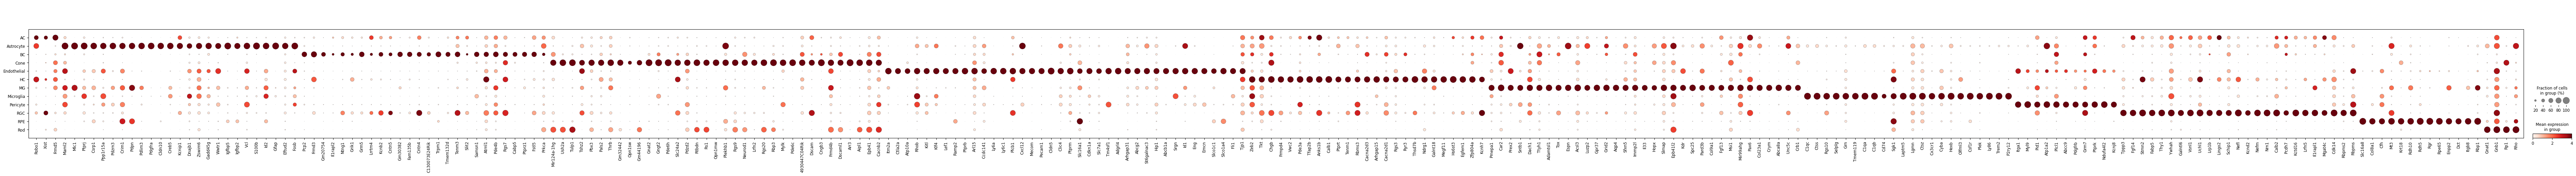

In [267]:
final_candidates_ordered = raw_feature_expression_pd_mean[final_candidates].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

In [345]:
feature_cell = raw_feature_expression_pd_mean[final_candidates].idxmax()
marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
top3markers = pd.DataFrame([marker_expression_mean, final_candidates, feature_cell]).T.sort_values(0).groupby(2).tail(3)[1].tolist()
top3markers

/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating key

/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating key

['Robo1',
 'Xist',
 'Frmd5',
 'Gnat1',
 'Plcl1',
 'Atp1a2',
 'Myl9',
 'Ly6c1',
 'Igfbp5',
 'Prkca',
 'Gnb1',
 'Cxcl12',
 'Grid2',
 'Acsl3',
 'Adamtsl1',
 'Pcp2',
 'Cntn5',
 'Thy1',
 'Thsd7b',
 'S100b',
 'Gfap',
 'Cldn5',
 'Nefl',
 'Hs6st3',
 'Calb1',
 'C1qa',
 'Hexb',
 'Ctss',
 'Rho',
 'Rdh5',
 'Opn1mw',
 'Arr3',
 'Rbp1',
 'Calb2',
 'Pde6h',
 'Rgr']

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


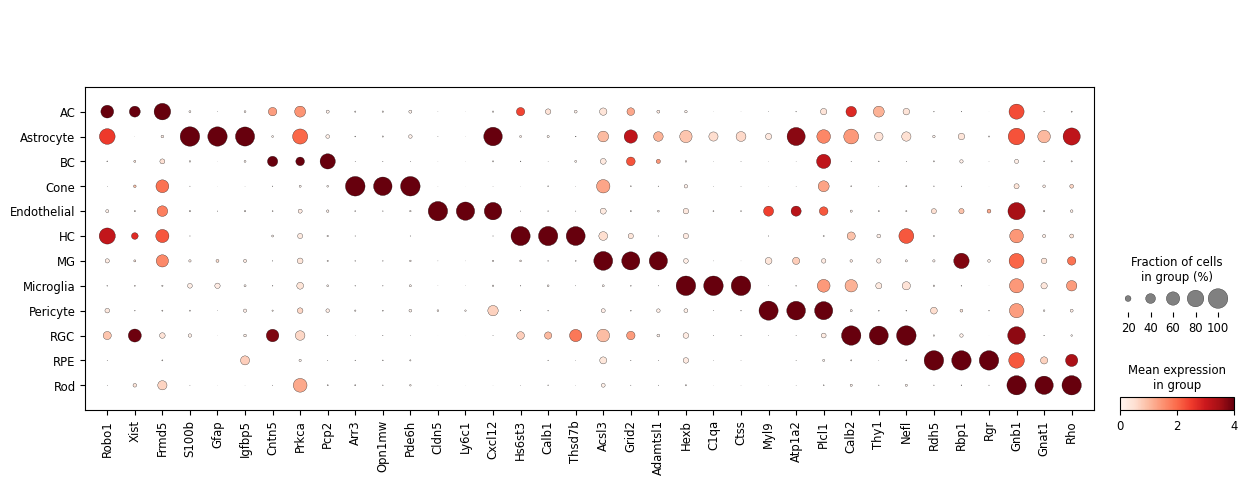

In [346]:
final_candidates_ordered = raw_feature_expression_pd_mean[top3markers].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_top3_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

In [349]:
raw_feature_expression_pd_mean.to_csv('spreadsheets/raw_majorclass_mean_expression.csv')

In [356]:
feature_expression_pd = pd.DataFrame(adata.X[:, adata.var["feature_name"].isin(final_candidates)].toarray(), columns=adata.var["feature_name"][adata.var["feature_name"].isin(final_candidates)])
feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
feature_expression_pd_mean = feature_expression_pd.groupby("majorclass").agg("mean")

In [358]:
feature_expression_pd_mean.to_csv('spreadsheets/normalized_majorclass_mean_expression.csv')

### Additional Inspection

In [409]:
long_enough = adata.var['feature_name'][adata.var["feature_length"].astype(int) >= 960] # It's a conservative filter

count_lowcluster = 4
count_highcluster = 100

features = raw_feature_expression_pd_mean.columns
#too_broad_genes = features[(raw_feature_expression_pd_mean >= count_highnoncluster).sum(axis=0) > 1]
detectable_genes = features[(raw_feature_expression_pd_mean >= count_lowcluster).sum(axis=0) >= 1]
#optical_crowding_genes = features[(raw_feature_expression_pd_mean >= count_highcluster).sum() > 0]

#poor_markers = np.union1d(optical_crowding_genes, too_broad_genes)
# expression_candidates = np.setdiff1d(detectable_genes, optical_crowding_genes)
# print(len(expression_candidates), expression_candidates)

candidates = np.intersect1d(long_enough, detectable_genes)
final_candidates = np.intersect1d(top_features_log_reg_pos.Gene.tolist(), candidates)
print(len(final_candidates), final_candidates)

175 ['Abca8a' 'Acsl3' 'Adgrl4' 'Aldoc' 'Anks1b' 'Apoe' 'Aqp4' 'Arhgap15'
 'Arl15' 'Arr3' 'Asic2' 'Atf3' 'Atp1a2' 'Bsg' 'C1qa' 'C1qb' 'C1qc' 'C1ql1'
 'Calb1' 'Calb2' 'Cald1' 'Cartpt' 'Ccn1' 'Cdh18' 'Chgb' 'Cldn5' 'Clu'
 'Cmss1' 'Cngb3' 'Col8a1' 'Col9a1' 'Creb5' 'Crip1' 'Csrp1' 'Ctla2a' 'Ctsd'
 'Ctss' 'Ctsz' 'Dbi' 'Dkk3' 'Dlc1' 'Dlgap1' 'Dmd' 'Dnajb1' 'Dock4' 'Ebf1'
 'Eftud2' 'Egfem1' 'Egr1' 'Epb41' 'Flt1' 'Fos' 'Fosb' 'Frmd5' 'Frmpd4'
 'Galnt18' 'Galntl6' 'Gfap' 'Glul' 'Gm20754' 'Gm32442' 'Gnat2' 'Gnb3'
 'Gng5' 'Gngt1' 'Gngt2' 'Gpr37' 'Gria4' 'Grik1' 'Grm5' 'Hexb' 'Hmgn1'
 'Hs6st3' 'Hspa1a' 'Id1' 'Igfbp7' 'Il1rapl1' 'Il33' 'Itm2a' 'Junb' 'Kcnd2'
 'Kctd16' 'Klf2' 'Laptm5' 'Lrfn2' 'Ly6a' 'Ly6c1' 'Ly86' 'Marchf1' 'Mecom'
 'Megf11' 'Mfge8' 'Mgp' 'Mlc1' 'Mt3' 'Myl9' 'Mylk' 'Nckap5' 'Ndrg1'
 'Ndufa4l2' 'Nebl' 'Nefl' 'Nefm' 'Nrn1' 'Opn1mw' 'Opn1sw' 'Pals2' 'Pcdh15'
 'Pcdh9' 'Pcp4' 'Pde3a' 'Pde6c' 'Pde6g' 'Pde6h' 'Pdgfrb' 'Plcb1' 'Plcl1'
 'Pltp' 'Ppp1r15a' 'Prdx6' 'Prkg1' 'Ptgds' 'Ptprb' 'Ptprk

In [412]:
feature_expression_pd = pd.DataFrame(adata.X[:, adata.var["feature_name"].isin(final_candidates)].toarray(), columns=adata.var["feature_name"][adata.var["feature_name"].isin(final_candidates)])
feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
heatmap_subset = feature_expression_pd.groupby("majorclass").agg("mean")
heatmap_values = (heatmap_subset - heatmap_subset.mean(axis=None)) / heatmap_subset.std(axis=None)

/tmp/ipykernel_246722/1682509194.py:4: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  heatmap_values = (heatmap_subset - heatmap_subset.mean(axis=None)) / heatmap_subset.std(axis=None)


In [413]:
heatmap_values = heatmap_values[heatmap_values.idxmax().sort_values().index]
heatmap_values.to_csv('spreadsheets/normalized_majorclass_Z_expression.csv')

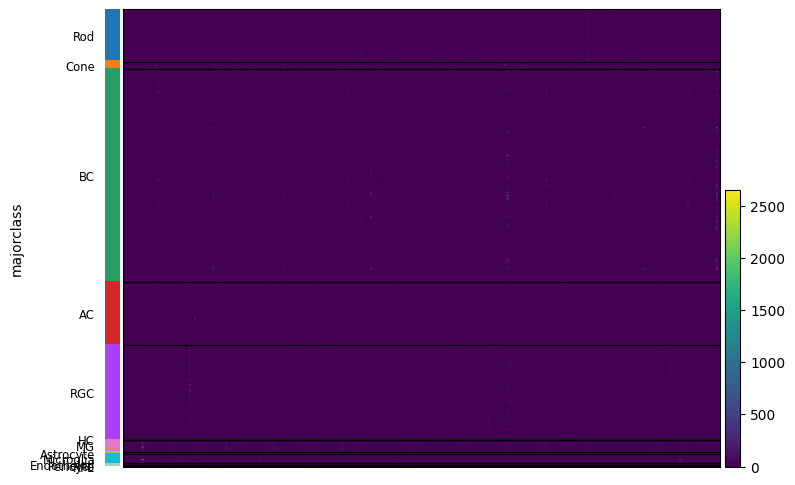

In [372]:
sc.pl.heatmap(adata[:, where_genes], groupby = 'majorclass', var_names = adata.var_names[where_genes])

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


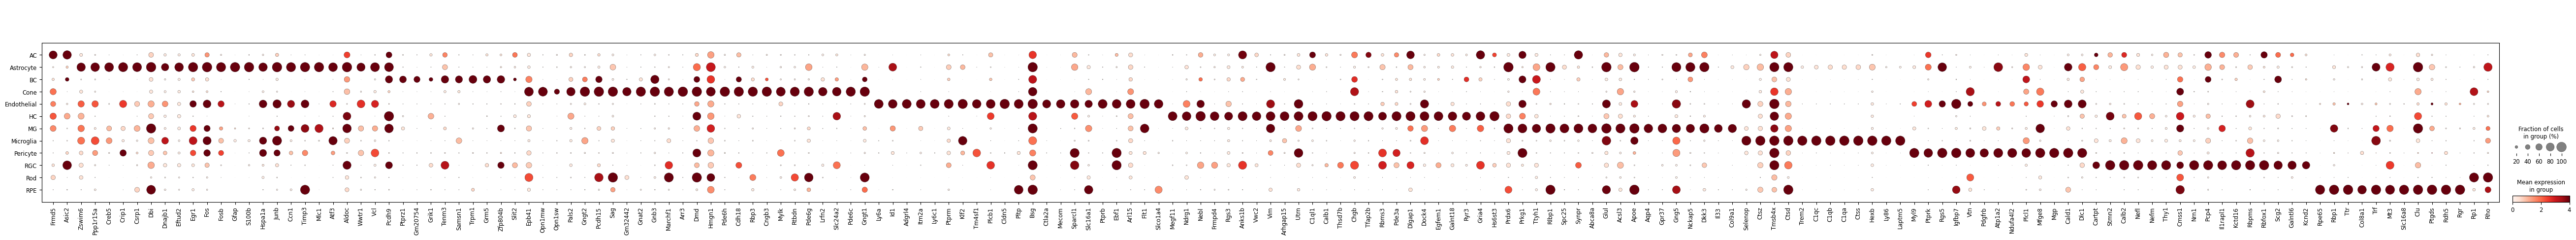

In [414]:
final_candidates_ordered = raw_feature_expression_pd_mean[final_candidates].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'Rod', 'RPE'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_length-detection-logistic_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


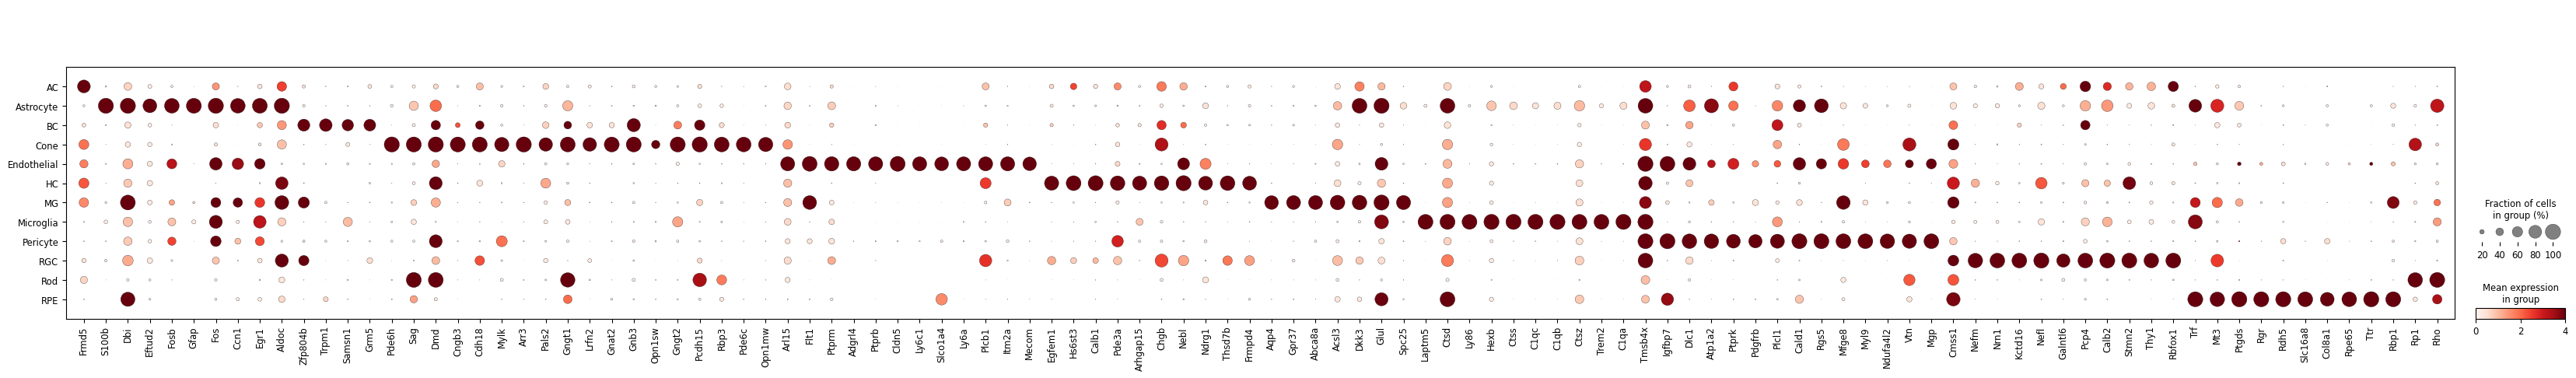

In [442]:
Zthres25 = heatmap_values.columns[((heatmap_values >= 2.5).sum(axis=0) == 1)]
final_candidates_ordered = raw_feature_expression_pd_mean[Zthres25].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'Rod', 'RPE'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_length-detection-logistic_Z2.5_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

## Subtype Markers

In [ ]:
top_features_log_reg_sub = pd.read_csv('spreadsheets/ovr_top_20_genes_by_sub_cell_type.csv')

In [23]:
top_features_log_reg_pos_sub = top_features_log_reg[top_features_log_reg['Coefficient'] > 0]
top_features_log_reg_pos_sub

,Cell Type,Gene,Coefficient
0,AC,Synpr,0.593647
1,AC,Asic2,0.561311
2,AC,Frmd5,0.557747
3,AC,Slc32a1,0.551331
4,AC,Gad1,0.517364
...,...,...,...
455,Rod,Epb41,0.272485
456,Rod,Pde6a,0.272482
457,Rod,Dmd,0.270124
458,Rod,Tmem108,0.264541


In [39]:
where_genes = adata.var["feature_name"].astype(str).isin(top_features_log_reg_pos["Gene"])
gene_names = adata.var["feature_name"].astype(str)[where_genes]

In [ ]:
# Now get average expression and percent expressed
feature_expression_pd_sub = pd.DataFrame(adata.X[:, where_genes].toarray(), columns=adata.vars['feature_name'][where_genes].tolist())
feature_expression_pd_sub["majorclass"] = adata.obs["majorclass"].tolist()
feature_expression_pd_sub_mean = feature_expression_pd_sub.groupby("majorclass").agg("mean")

In [221]:
# Raw reads
highly_variable = adata.raw.var['feature_name'].isin(adata.var['feature_name'])
raw_feature_expression_pd_sub = pd.DataFrame(adata.raw.X[:, highly_variable].toarray())
raw_feature_expression_pd_sub["majorclass"] = adata.obs["majorclass"].tolist()
raw_feature_expression_pd_sub_mean = raw_feature_expression_pd_sub.groupby("majorclass").agg("mean")
raw_feature_expression_pd_sub_mean.columns = adata.var["feature_name"].astype(str) # gene_names.tolist()

In [145]:
# Filter based on innate features of the gene itself
pre_filtered = adata.var["feature_is_filtered"] == False # variable genes, none filtered
long_enough = adata.var["feature_length"].astype(int) >= 960 # It's a conservative filter
is_known = adata.var["feature_name"].isin(known_markers)
with open("mentioned_genes.txt", 'r') as f:
    mentioned_genes = f.readlines()
mentioned_genes = [gene.strip() for gene in mentioned_genes]
is_mentioned = adata.var["feature_name"].isin(mentioned_genes)

keep_genes = (pre_filtered & long_enough) | is_mentioned
kept_gene_names = adata.var["feature_name"][keep_genes].tolist()
kept_gene_names # 2049 genes still

['0610038B21Rik',
 '1110018N20Rik',
 'Cstpp1',
 '1190005I06Rik',
 '1600010M07Rik',
 '1700008O03Rik',
 'Zbed5-ps',
 '1700026F02Rik',
 '1700028E10Rik',
 '1700029J07Rik',
 '1700030J22Rik',
 '1700088E04Rik',
 '1700096K18Rik',
 '1700120C14Rik',
 '2310026I22Rik',
 '2310058D17Rik',
 '2410018L13Rik',
 '2610020C07Rik',
 '2810030D12Rik',
 '2810403D21Rik',
 '3010001F23Rik',
 '3222401L13Rik',
 '4833428L15Rik',
 '4921511C10Rik',
 '4930405A21Rik',
 '4930419G24Rik',
 '4930447C04Rik',
 '4930467D21Rik',
 '4930509J09Rik',
 '4930512H18Rik',
 '4930555F03Rik',
 '4930556J24Rik',
 '4930556N13Rik',
 '4930581F22Rik',
 '4931414P19Rik',
 '4931415C17Rik',
 '4933406J10Rik',
 '4933413L06Rik',
 '5033421B08Rik',
 'Cdcp3',
 '5730419F03Rik',
 '5730522E02Rik',
 '5830408C22Rik',
 '6330411D24Rik',
 '6430562O15Rik',
 '6530402F18Rik',
 '8430419K02Rik',
 '9330020H09Rik',
 '9330154J02Rik',
 '9330158H04Rik',
 'A1bg',
 'A230077H06Rik',
 'A230083G16Rik',
 'A2m',
 'A330008L17Rik',
 'A330015K06Rik',
 'A330094K24Rik',
 'A430035B10R

In [253]:
# Filter based on the filtering criteria
# adata.obs.library_platform.unique() # mix of 4 chemistries...
count_noncluster = 0.1
count_highnoncluster = 4
count_lowcluster = 4
count_highcluster = 100

features = raw_feature_expression_pd_mean.columns
too_broad_genes = features[(raw_feature_expression_pd_mean >= count_highnoncluster).sum(axis=0) > 1]
detectable_genes = features[(raw_feature_expression_pd_mean >= count_lowcluster).sum(axis=0) >= 1]
optical_crowding_genes = features[(raw_feature_expression_pd_mean >= count_highcluster).sum() > 0]

poor_markers = np.union1d(optical_crowding_genes, too_broad_genes)
expression_candidates = np.setdiff1d(detectable_genes, poor_markers)
print(len(expression_candidates), expression_candidates)

281 ['4930447C04Rik' 'Abca8a' 'Abcb1a' 'Abcc9' 'Abcg2' 'Acsl3' 'Adamtsl1'
 'Adgrl4' 'Aipl1' 'Anks1b' 'Aqp4' 'Arhgap15' 'Arhgap31' 'Arl15' 'Arr3'
 'Atp10a' 'Atp1a2' 'Atrnl1' 'C130073E24Rik' 'C1qa' 'C1qb' 'C1qc' 'Cabp5'
 'Cacna2d1' 'Cacna2d3' 'Cacnb2' 'Calb1' 'Calb2' 'Car2' 'Ccdc141' 'Ccl12'
 'Ccl3' 'Ccl4' 'Cd74' 'Cdk14' 'Cdkn1a' 'Cfh' 'Chgb' 'Cldn10' 'Cldn5'
 'Clic4' 'Cngb3' 'Cntn4' 'Cntn5' 'Col23a1' 'Col8a1' 'Col9a1' 'Cox4i2'
 'Cox8b' 'Crb1' 'Creb5' 'Crim1' 'Crym' 'Csf1r' 'Csrp1' 'Ctla2a' 'Ctss'
 'Ctsz' 'Cx3cr1' 'Cxcl12' 'Cyba' 'Dach1' 'Dapl1' 'Dct' 'Dnajb1' 'Dscam'
 'Dscaml1' 'Eftud2' 'Egfem1' 'Emcn' 'Eng' 'Enpp2' 'Epb41' 'Epb41l2' 'Espn'
 'Fabp5' 'Fam135b' 'Fcer1g' 'Fgf13' 'Fgf14' 'Fli1' 'Fosb' 'Frmd3' 'Frmd4b'
 'Frmd5' 'Frmpd4' 'Fstl5' 'Fxyd7' 'Gadd45g' 'Galnt18' 'Galntl6' 'Gfap'
 'Gm11906' 'Gm20754' 'Gm30382' 'Gm32442' 'Gm44196' 'Gm4792' 'Gnat1'
 'Gnat2' 'Gnb1' 'Gng11' 'Gng13' 'Gngt2' 'Gpr37' 'Grid2' 'Grik1' 'Grm5'
 'Grm7' 'Grn' 'Hba-a1' 'Hba-a2' 'Hbb-bs' 'Hexb' 'Higd1b' 'Hip1' 'Ho

In [254]:
final_candidates = np.intersect1d(expression_candidates, kept_gene_names)
print(len(final_candidates), final_candidates)

260 ['4930447C04Rik' 'Abca8a' 'Abcb1a' 'Abcc9' 'Abcg2' 'Acsl3' 'Adamtsl1'
 'Adgrl4' 'Aipl1' 'Anks1b' 'Aqp4' 'Arhgap15' 'Arhgap31' 'Arl15' 'Arr3'
 'Atp10a' 'Atp1a2' 'Atrnl1' 'C130073E24Rik' 'C1qa' 'C1qb' 'C1qc' 'Cabp5'
 'Cacna2d1' 'Cacna2d3' 'Cacnb2' 'Calb1' 'Calb2' 'Car2' 'Ccdc141' 'Cd74'
 'Cdk14' 'Cdkn1a' 'Cfh' 'Chgb' 'Cldn10' 'Cldn5' 'Clic4' 'Cngb3' 'Cntn4'
 'Cntn5' 'Col23a1' 'Col8a1' 'Col9a1' 'Crb1' 'Creb5' 'Crim1' 'Crym' 'Csf1r'
 'Csrp1' 'Ctla2a' 'Ctss' 'Ctsz' 'Cx3cr1' 'Cxcl12' 'Cyba' 'Dach1' 'Dct'
 'Dnajb1' 'Dscam' 'Dscaml1' 'Eftud2' 'Egfem1' 'Emcn' 'Eng' 'Enpp2' 'Epb41'
 'Epb41l2' 'Espn' 'Fabp5' 'Fam135b' 'Fgf13' 'Fgf14' 'Fli1' 'Fosb' 'Frmd3'
 'Frmd4b' 'Frmd5' 'Frmpd4' 'Fstl5' 'Gadd45g' 'Galnt18' 'Galntl6' 'Gfap'
 'Gm20754' 'Gm30382' 'Gm32442' 'Gm44196' 'Gnat1' 'Gnat2' 'Gnb1' 'Gngt2'
 'Gpr37' 'Grid2' 'Grik1' 'Grm5' 'Grm7' 'Grn' 'Hexb' 'Hip1' 'Hopx' 'Hs6st3'
 'Id1' 'Id2' 'Igfbp2' 'Igfbp5' 'Il1rapl1' 'Il1rapl2' 'Il33' 'Immp2l'
 'Itga1' 'Itgb8' 'Itm2a' 'Kcnb2' 'Kcnd2' 'Kcnh7' 'Kcnip

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


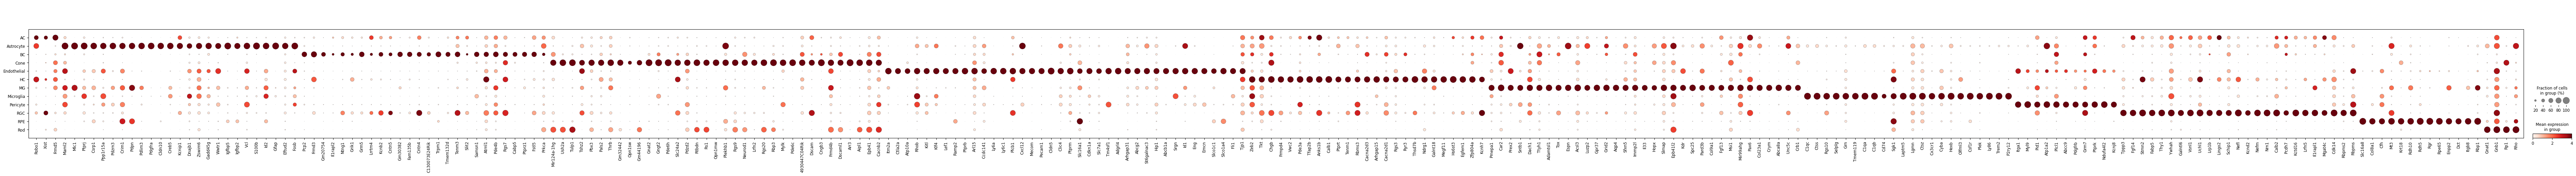

In [267]:
final_candidates_ordered = raw_feature_expression_pd_mean[final_candidates].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

In [345]:
feature_cell = raw_feature_expression_pd_mean[final_candidates].idxmax()
marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
top3markers = pd.DataFrame([marker_expression_mean, final_candidates, feature_cell]).T.sort_values(0).groupby(2).tail(3)[1].tolist()
top3markers

/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating key

/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  marker_expression_mean = [raw_feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(raw_feature_expression_pd_mean[final_candidates].T.index)]
/tmp/ipykernel_246722/568512176.py:2: FutureWarning: Series.__getitem__ treating key

['Robo1',
 'Xist',
 'Frmd5',
 'Gnat1',
 'Plcl1',
 'Atp1a2',
 'Myl9',
 'Ly6c1',
 'Igfbp5',
 'Prkca',
 'Gnb1',
 'Cxcl12',
 'Grid2',
 'Acsl3',
 'Adamtsl1',
 'Pcp2',
 'Cntn5',
 'Thy1',
 'Thsd7b',
 'S100b',
 'Gfap',
 'Cldn5',
 'Nefl',
 'Hs6st3',
 'Calb1',
 'C1qa',
 'Hexb',
 'Ctss',
 'Rho',
 'Rdh5',
 'Opn1mw',
 'Arr3',
 'Rbp1',
 'Calb2',
 'Pde6h',
 'Rgr']

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


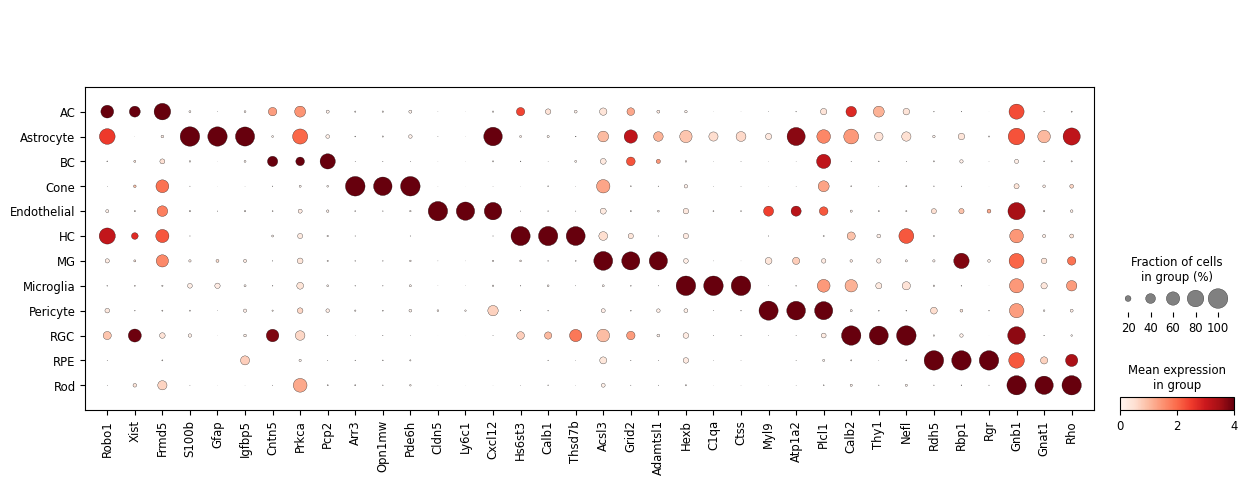

In [346]:
final_candidates_ordered = raw_feature_expression_pd_mean[top3markers].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_top3_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

In [349]:
raw_feature_expression_pd_mean.to_csv('spreadsheets/raw_majorclass_mean_expression.csv')

In [356]:
feature_expression_pd = pd.DataFrame(adata.X[:, adata.var["feature_name"].isin(final_candidates)].toarray(), columns=adata.var["feature_name"][adata.var["feature_name"].isin(final_candidates)])
feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
feature_expression_pd_mean = feature_expression_pd.groupby("majorclass").agg("mean")

In [358]:
feature_expression_pd_mean.to_csv('spreadsheets/normalized_majorclass_mean_expression.csv')